In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# import from warning
from tqdm.autonotebook import tqdm

import tensorflow as tf
import tensorboard as tb

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
os.chdir('../..')

In [4]:
os.getcwd()

'c:\\Users\\maxim\\Documents\\GitHub\\gold-forecast'

In [5]:
df = pd.read_csv('data/data_nominal_clean.csv', sep=';', parse_dates=['date'])

In [6]:
from pandas.plotting import lag_plot

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 20)'>

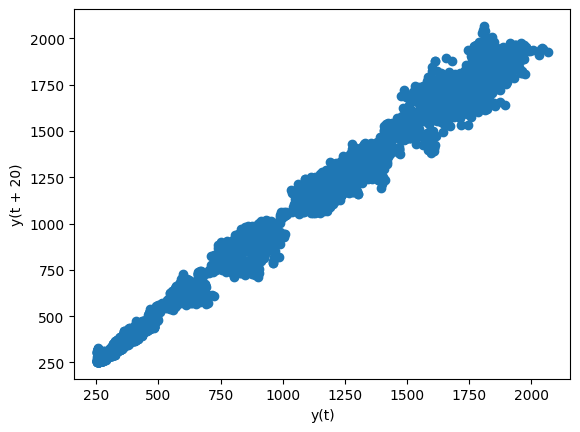

In [7]:
lag_plot(df.Gold, lag=20)

In [8]:
dataset = df.shift(20)
dataset['Gold_y'] = df['Gold']
dataset['grp'] = 1
dataset.dropna(inplace=True)
dataset['time_idx'] = dataset.reset_index(drop=True).index
dataset

,date,Gold,CrudeOil,S&P500,FTSE250,Gold_y,grp,time_idx
20,1986-01-02,326.30,25.56,209.59,1417.26,358.00,1,0
21,1986-01-03,326.75,26.00,210.88,1424.61,350.50,1,1
22,1986-01-06,328.00,26.53,210.65,1430.96,347.30,1,2
23,1986-01-07,330.00,25.85,213.80,1421.22,338.60,1,3
24,1986-01-08,332.60,25.87,207.97,1408.79,337.30,1,4
...,...,...,...,...,...,...,...,...
9144,2022-11-30,1753.50,80.48,4080.11,19163.33,1813.75,1,9124
9145,2022-12-01,1803.15,81.06,4076.57,19409.42,1843.25,1,9125
9146,2022-12-02,1784.75,79.86,4071.70,19363.28,1857.30,1,9126
9147,2022-12-05,1776.80,76.83,3998.84,19329.58,1834.00,1,9127


In [9]:
dataset.dtypes

date        datetime64[ns]
Gold               float64
CrudeOil           float64
S&P500             float64
FTSE250            float64
Gold_y             float64
grp                  int64
time_idx             int64
dtype: object

In [10]:
train = dataset#.iloc[:-20]
#val = dataset.iloc[-20:]

In [11]:
max_prediction_length = 20 # We will predict last 20 days 
max_encoder_length = max_prediction_length*4
training_cutoff = train["time_idx"].max() - max_prediction_length #we will validate on 2020

In [12]:
training_cutoff

9108

In [15]:
# Let's create a Dataset
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx<=training_cutoff],
    target="Gold_y",
    group_ids= ["grp"],
    time_idx="time_idx",
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Gold_y","CrudeOil","S&P500","FTSE250"],
    target_normalizer=GroupNormalizer(
        groups=["grp"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    train,
    predict=True,
    stop_randomization=True
)

In [22]:
batch_size = 32

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=7)
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size*10, num_workers=7)

#load the first batch
x, y = next(iter(train_dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[1005.5000, 1038.7500, 1040.2500,  ..., 1094.7500, 1088.0000,
         1078.5000],
        [ 275.4500,  275.6000,  280.0000,  ...,  274.6000,  273.4000,
          273.1500],
        [ 398.9500,  401.7000,  400.4000,  ...,  453.0000,  449.0000,
          453.2500],
        ...,
        [1281.2500, 1288.5000, 1288.0000,  ..., 1214.3000, 1210.5000,
         1205.0000],
        [ 282.0000,  281.7500,  281.1000,  ...,  273.1000,  272.0000,
          272.2000],
        [1813.5000, 1821.0000, 1875.2500,  ..., 1613.5000, 1608.0000,
         1606.5000]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


tensor([[1086.5000, 1

In [17]:
#load the first batch
# x, y = next(iter(val_dataloader))
# print(x['encoder_target'])
# print(x['groups'])
# print('\n')
# print(x['decoder_target'])

In [23]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


18.81517219543457

In [24]:

early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=5,
    accelerator='auto', 
    devices='auto',
    enable_model_summary=True,
    gradient_clip_val=0.01,
    fast_dev_run=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=1,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=0, 
    reduce_on_plateau_patience=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [25]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
    )


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 504   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 960   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 150   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 0: 100%|██████████| 1/1 [00:27<00:00, 27.33s/it, v_num=, train_loss_step=493.0, val_loss=225.0, train_loss_epoch=493.0]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:27<00:00, 27.35s/it, v_num=, train_loss_step=493.0, val_loss=225.0, train_loss_epoch=493.0]


In [16]:
best_model_path = trainer.checkpoint_callback.on_load_checkpoint
print(best_model_path)

<bound method Callback.on_load_checkpoint of <lightning.pytorch.callbacks.model_checkpoint.ModelCheckpoint object at 0x000001EDC42B8D60>>


In [37]:
# best_model_path = trainer.checkpoint_callback.on_load_checkpoint
# print(best_model_path)
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path, strict=False)

In [24]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [30]:
predictions = tft.predict(val_dataloader, return_y=True, mode="prediction", trainer_kwargs=dict(accelerator="cpu"))

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 320 but got size 130 for tensor number 28 in the list.

In [29]:
predictions.output

torch.Size([9090, 20])

In [31]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

In [34]:
raw_predictions.output

Output(prediction=tensor([[[612.3041, 637.8889, 631.0822,  ..., 509.0541, 905.3227, 796.8533],
         [646.3699, 637.3783, 639.0499,  ..., 526.6398, 893.8408, 786.7572],
         [669.3671, 639.2518, 644.6478,  ..., 541.6255, 880.5900, 779.3555],
         ...,
         [750.7092, 636.5762, 676.5641,  ..., 599.2328, 821.3488, 741.9077],
         [753.8751, 635.8025, 677.7890,  ..., 601.4227, 819.5312, 740.2941],
         [757.0203, 635.0468, 679.0748,  ..., 603.5386, 817.7723, 738.7231]],

        [[612.3761, 637.8665, 631.1710,  ..., 508.8386, 905.5433, 796.8004],
         [646.4587, 637.3799, 639.1279,  ..., 526.4976, 893.9860, 786.6735],
         [669.4660, 639.2650, 644.7296,  ..., 541.5208, 880.7007, 779.2525],
         ...,
         [750.7858, 636.5965, 676.6328,  ..., 599.2066, 821.3953, 741.8164],
         [753.9506, 635.8222, 677.8564,  ..., 601.3982, 819.5761, 740.2044],
         [757.0945, 635.0660, 679.1411,  ..., 603.5156, 817.8157, 738.6349]],

        [[612.4437, 637.81

In [1]:
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=1, add_loss_to_title=True)

NameError: name 'tft' is not defined

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Gold_y_center': <Figure size 1000x500 with 2 Axes>,
 'Gold_y_scale': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Gold_y': <Figure size 1000x500 with 2 Axes>,
 'CrudeOil': <Figure size 1000x500 with 2 Axes>,
 'S&P500': <Figure size 1000x500 with 2 Axes>,
 'FTSE250': <Figure size 1000x500 with 2 Axes>}

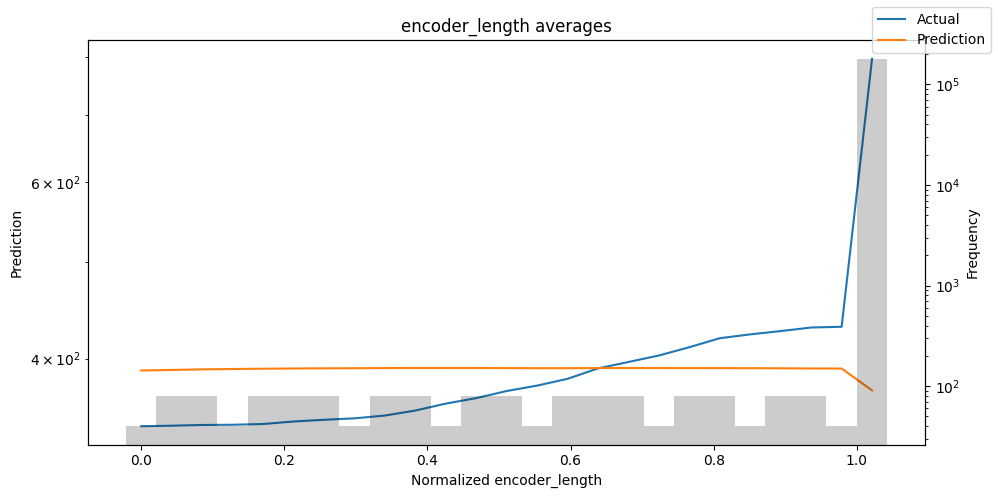

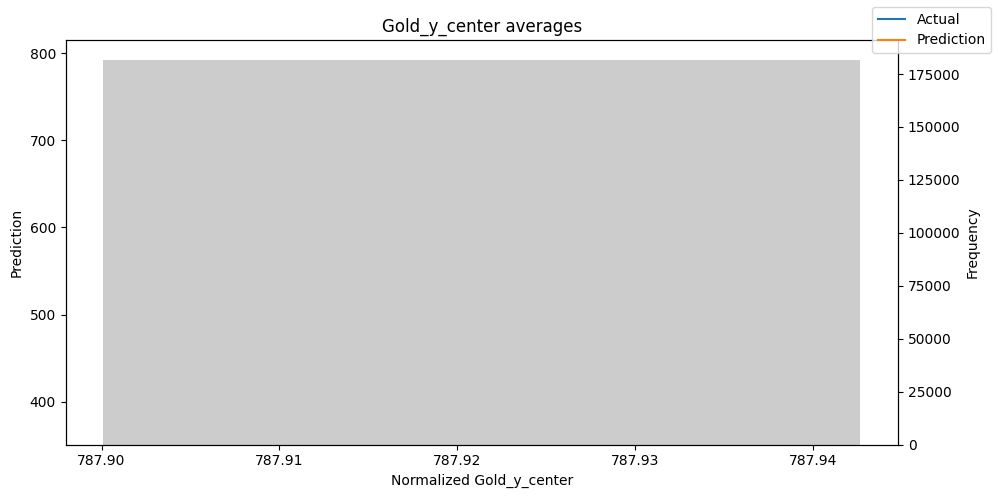

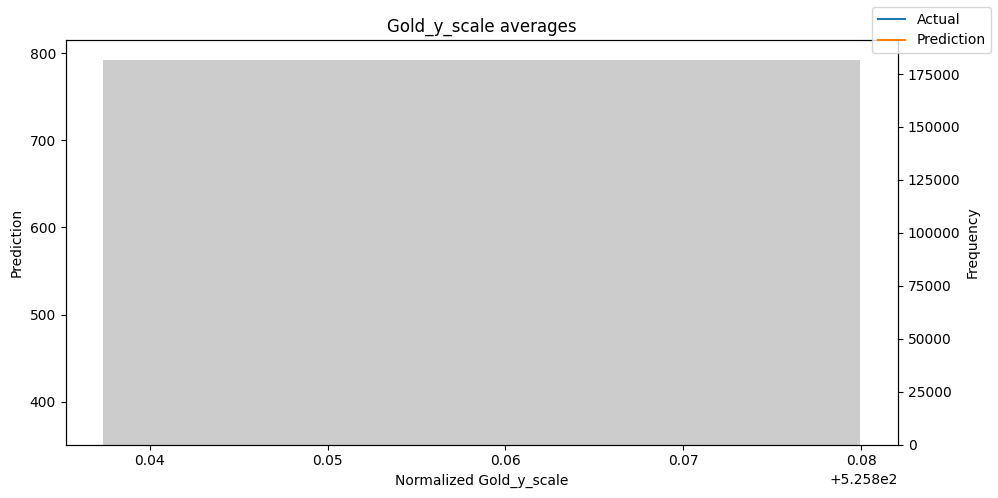

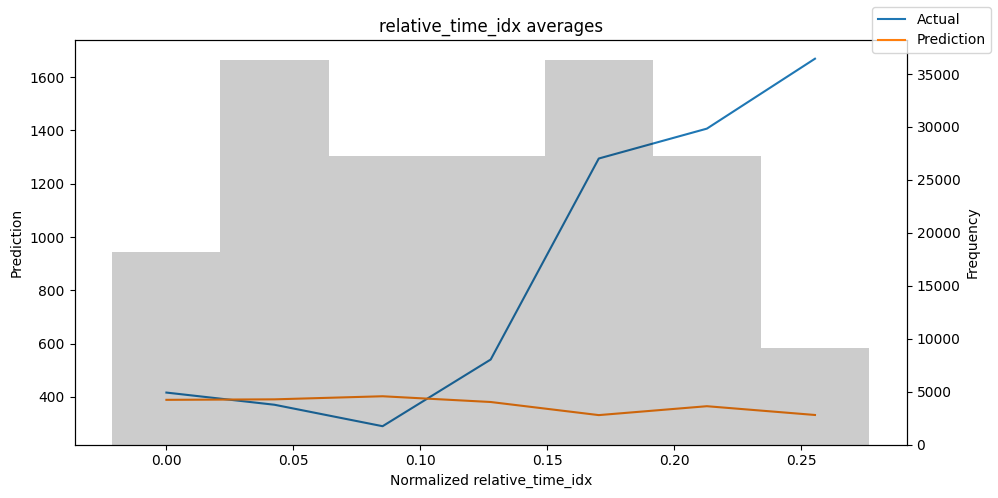

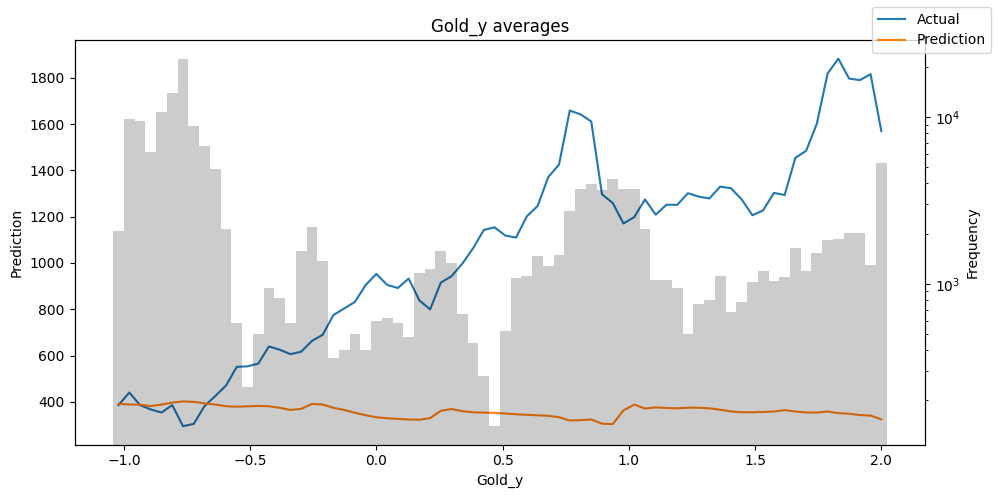

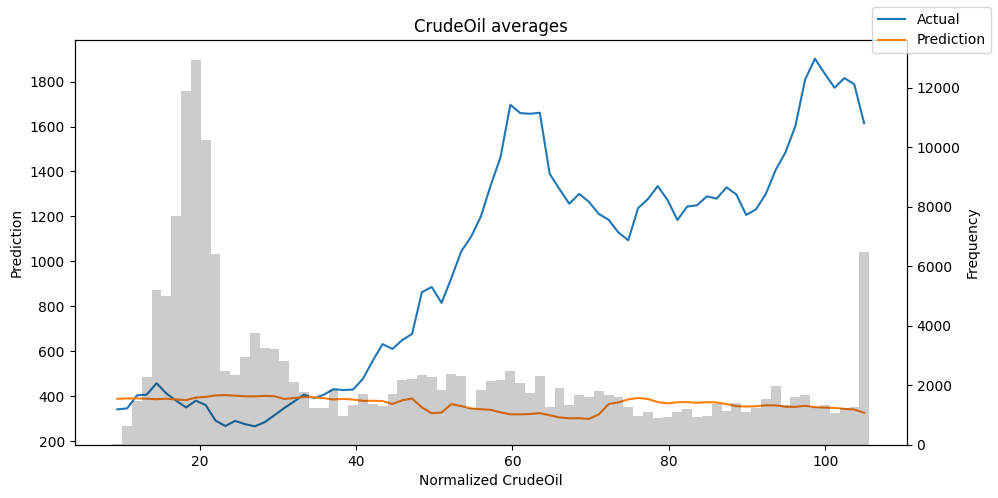

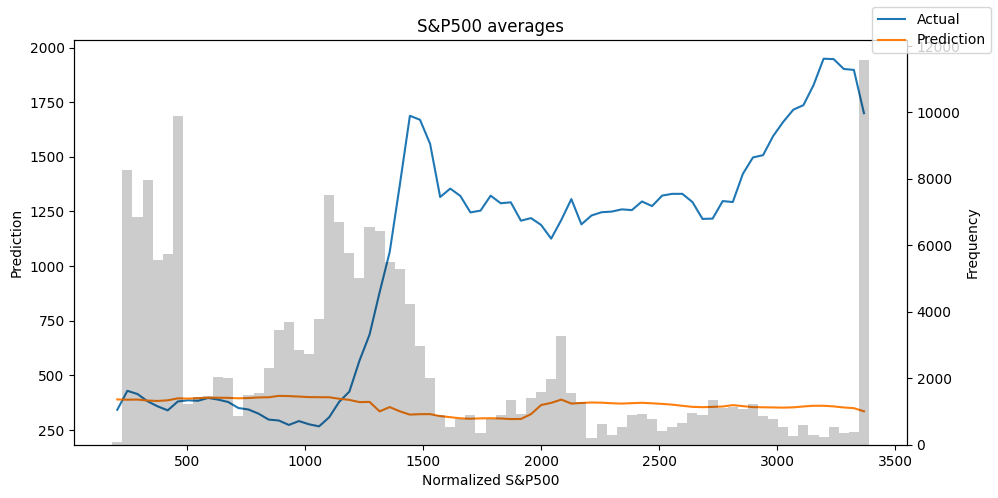

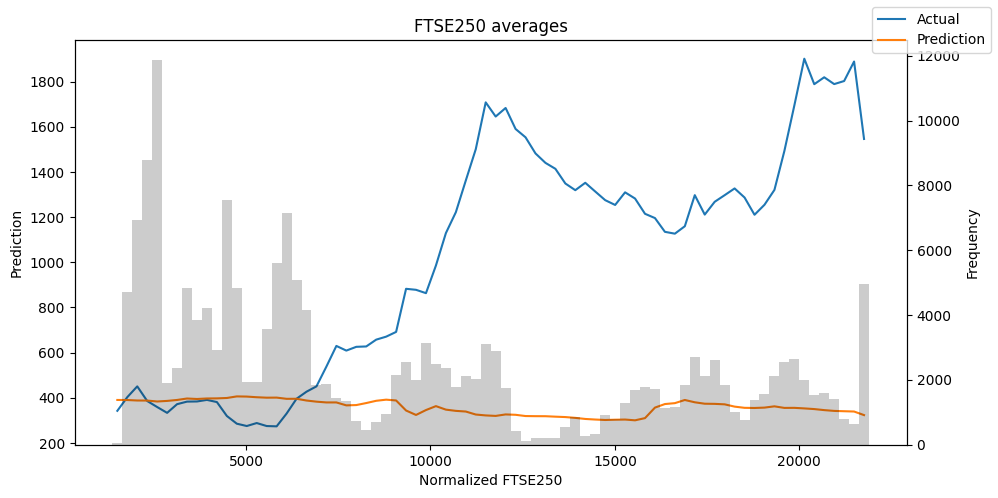

In [37]:
predictions = tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x325 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

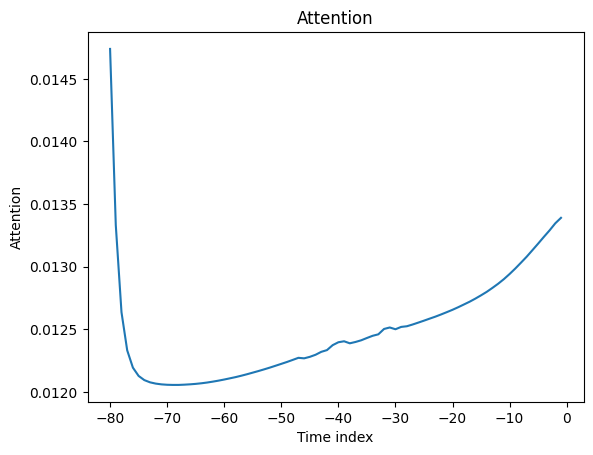

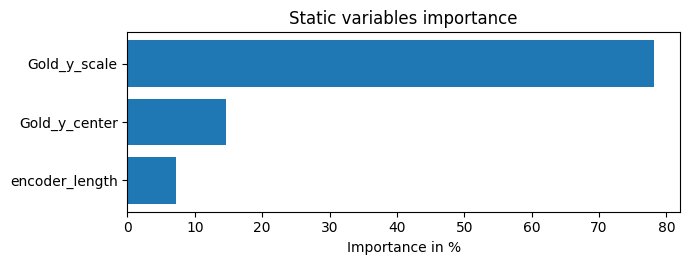

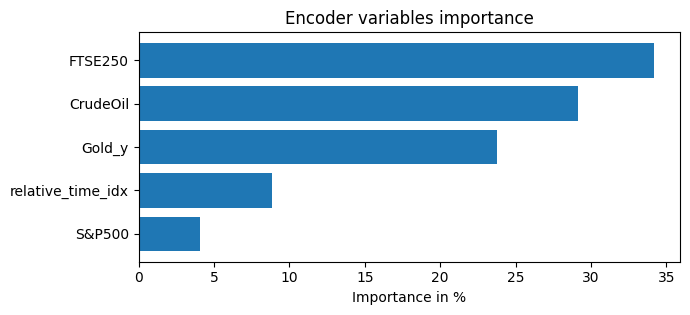

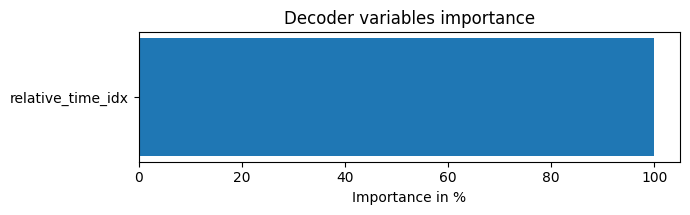

In [38]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)